In [1]:
import numpy as np
import pandas as pd
from keras import layers
from keras import models
import tensorflow as tf
import tensorboard
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from matplotlib import pyplot as plt

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2023-03-08 20:20:04.558957: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 20:20:04.698374: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-08 20:20:05.487538: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/bjbae/miniconda3/envs/ml/lib/
2023-03-08 20:20:05.489915: W tensorflow/compiler/xla/stream_

Num GPUs Available:  1


2023-03-08 20:20:07.128562: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-08 20:20:07.167694: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-08 20:20:07.167955: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
# load dataset
# encoding error with degrees symbol in utf-8
df = pd.read_csv("./SeoulBikeData.csv",
                 encoding_errors="ignore")

# data cleaning removing measurement labels
rename_dict = {}
rename_dict["Temperature(C)"] = "Temperature"
rename_dict["Humidity(%)"] = "Humidity"
rename_dict["Wind speed (m/s)"] = "Wind speed"
rename_dict["Visibility (10m)"] = "Visibility"
rename_dict["Dew point temperature(C)"] = "Dew point temperature"
rename_dict["Solar Radiation (MJ/m2)"] = "Solar Radiation"
rename_dict["Rainfall(mm)"] = "Rainfall"
rename_dict["Snowfall (cm)"] = "Snowfall"
df.rename(columns=rename_dict, inplace=True)

In [3]:
# Predict Rented Bike Count
# Predictors Hour, Temp, Hum, Solar Rad, Rain, Snow, Seasons, Holiday
# Filter Functional Day (Times where bike sharing was unavailible)

# print(df.columns)
# print(df.describe())
# print(df["Functioning Day"].describe())
# print(df.shape)

# df_EDA = df.loc[df["Functioning Day"] != "Yes", :]
# print(df_EDA)

In [4]:
# First filter valid rows
df_filtered = df.loc[df["Functioning Day"] == "Yes", :]

# Create Predicted and Predictors
X = df_filtered.iloc[:, 2:13]
y = df_filtered.loc[:, "Rented Bike Count"]

# Encode values in X
X = pd.get_dummies(X, drop_first=True)
X = pd.get_dummies(X, columns=["Hour"], drop_first=True)
print(X.columns)

Index(['Temperature', 'Humidity', 'Wind speed', 'Visibility',
       'Dew point temperature', 'Solar Radiation', 'Rainfall', 'Snowfall',
       'Seasons_Spring', 'Seasons_Summer', 'Seasons_Winter',
       'Holiday_No Holiday', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5',
       'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12',
       'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18',
       'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23'],
      dtype='object')


In [5]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=22)

std = StandardScaler()
ct = ColumnTransformer([
    ('std', StandardScaler(), list(rename_dict.values()))
], remainder='passthrough')
ct.fit_transform(X_train, y_test)
ct.transform(X_test)
print(X_train.head())
print(X_train.describe())

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

      Temperature  Humidity  Wind speed  Visibility  Dew point temperature  \
5591         28.8        56         1.6        2000                   19.1   
5990         34.0        50         1.2        1744                   22.1   
4563         19.1        84         0.6         421                   16.3   
7837         13.5        82         0.8         962                   10.4   
3109         12.4        32         1.7        1441                   -3.8   

      Solar Radiation  Rainfall  Snowfall  Seasons_Spring  Seasons_Summer  \
5591             0.00       0.0       0.0               0               1   
5990             1.68       0.0       0.0               0               1   
4563             0.00       0.0       0.0               0               1   
7837             1.33       0.0       0.0               0               0   
3109             3.06       0.0       0.0               1               0   

      ...  Hour_14  Hour_15  Hour_16  Hour_17  Hour_18  Hour_19  Hou

In [6]:
num_epochs = 20

## Model 1

In [7]:
# Create the model

model = models.Sequential()
model.add(layers.Dense(8, input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 288       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 369
Trainable params: 369
Non-trainable params: 0
_________________________________________________________________


2023-03-08 20:20:07.350896: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 20:20:07.361646: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-08 20:20:07.361959: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-08 20:20:07.362157: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0

In [8]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(
    X_test, y_test), batch_size=1, verbose=True, callbacks=[tensorboard_callback])
model.evaluate(X_test, y_test)

Epoch 1/20


2023-03-08 20:20:31.403138: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-08 20:20:31.433023: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f1a7186d820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-08 20:20:31.433061: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-03-08 20:20:31.544031: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-08 20:20:32.256731: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-08 20:20:32.384702: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most on

5925/5925 [==============================] - 28s 4ms/step - loss: 450663.3125 - mae: 504.2795 - val_loss: 358377.3750 - val_mae: 429.2833
Epoch 2/20
5925/5925 [==============================] - 22s 4ms/step - loss: 329640.3125 - mae: 429.4335 - val_loss: 340507.0000 - val_mae: 405.6692
Epoch 3/20
5925/5925 [==============================] - 22s 4ms/step - loss: 303498.8750 - mae: 403.6674 - val_loss: 375713.6562 - val_mae: 418.7847
Epoch 4/20
5925/5925 [==============================] - 23s 4ms/step - loss: 284965.5938 - mae: 388.6987 - val_loss: 389774.2188 - val_mae: 427.7973
Epoch 5/20
5925/5925 [==============================] - 23s 4ms/step - loss: 278046.7500 - mae: 382.3819 - val_loss: 318121.4688 - val_mae: 384.4241
Epoch 6/20
5925/5925 [==============================] - 23s 4ms/step - loss: 270217.9062 - mae: 375.8621 - val_loss: 311019.7812 - val_mae: 378.6456
Epoch 7/20
5925/5925 [==============================] - 23s 4ms/step - loss: 258986.2969 - mae: 366.8185 - val_loss: 

[149377.453125, 265.5701904296875]

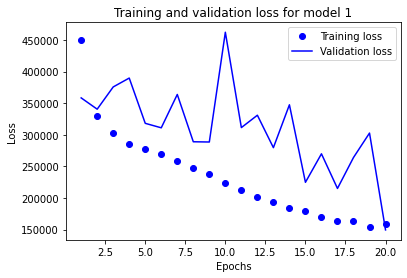

In [9]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for model 1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('images/model1.png', dpi=1200, bbox_inches="tight")

plt.show()

## Model 2

In [10]:
model = models.Sequential()
model.add(layers.Dense(8, input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8)                 288       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 8)                 72        
                                                                 
 dropout_3 (Dropout)         (None, 8)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 369
Trainable params: 369
Non-trainable params: 0
_________________________________________________________________


In [11]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(
    X_test, y_test), batch_size=10, verbose=True, callbacks=[tensorboard_callback])
model.evaluate(X_test, y_test)

Epoch 1/20
593/593 [==============================] - 4s 5ms/step - loss: 504364.4688 - mae: 528.5417 - val_loss: 438010.2500 - val_mae: 486.3686
Epoch 2/20
593/593 [==============================] - 3s 5ms/step - loss: 423184.5000 - mae: 487.2727 - val_loss: 387715.4375 - val_mae: 455.3090
Epoch 3/20
593/593 [==============================] - 3s 5ms/step - loss: 373789.4688 - mae: 457.1048 - val_loss: 355810.1562 - val_mae: 422.6604
Epoch 4/20
593/593 [==============================] - 3s 5ms/step - loss: 343776.0312 - mae: 433.0758 - val_loss: 385924.1875 - val_mae: 422.4438
Epoch 5/20
593/593 [==============================] - 3s 5ms/step - loss: 321193.4062 - mae: 416.9143 - val_loss: 344067.6562 - val_mae: 405.4535
Epoch 6/20
593/593 [==============================] - 3s 5ms/step - loss: 303653.9062 - mae: 404.6757 - val_loss: 336848.5312 - val_mae: 400.9014
Epoch 7/20
593/593 [==============================] - 3s 5ms/step - loss: 299209.9062 - mae: 403.4185 - val_loss: 364878.375

[307137.9375, 370.67816162109375]

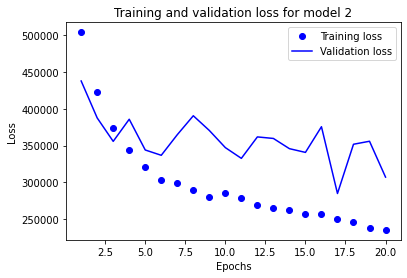

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for model 2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('images/model2.png', dpi=1200, bbox_inches="tight")

plt.show()

## Model 3

In [13]:
model = models.Sequential()
model.add(layers.Dense(8, input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 8)                 288       
                                                                 
 dropout_4 (Dropout)         (None, 8)                 0         
                                                                 
 dense_7 (Dense)             (None, 8)                 72        
                                                                 
 dropout_5 (Dropout)         (None, 8)                 0         
                                                                 
 dense_8 (Dense)             (None, 1)                 9         
                                                                 
Total params: 369
Trainable params: 369
Non-trainable params: 0
_________________________________________________________________


In [14]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(
    X_test, y_test), batch_size=20, verbose=True, callbacks=[tensorboard_callback])
model.evaluate(X_test, y_test)

Epoch 1/20
297/297 [==============================] - 2s 6ms/step - loss: 611904.2500 - mae: 572.9536 - val_loss: 461413.9062 - val_mae: 494.5358
Epoch 2/20
297/297 [==============================] - 1s 5ms/step - loss: 479245.6875 - mae: 519.2294 - val_loss: 431271.9688 - val_mae: 477.0691
Epoch 3/20
297/297 [==============================] - 1s 5ms/step - loss: 426398.0000 - mae: 489.6457 - val_loss: 373427.3125 - val_mae: 446.4036
Epoch 4/20
297/297 [==============================] - 1s 5ms/step - loss: 375725.3438 - mae: 454.1896 - val_loss: 335228.8438 - val_mae: 423.5062
Epoch 5/20
297/297 [==============================] - 1s 4ms/step - loss: 348363.8438 - mae: 438.4276 - val_loss: 347042.5625 - val_mae: 409.8479
Epoch 6/20
297/297 [==============================] - 2s 5ms/step - loss: 322027.0625 - mae: 418.7725 - val_loss: 325086.1250 - val_mae: 399.7555
Epoch 7/20
297/297 [==============================] - 1s 5ms/step - loss: 307175.9688 - mae: 407.3861 - val_loss: 340584.250

[375594.71875, 430.89324951171875]

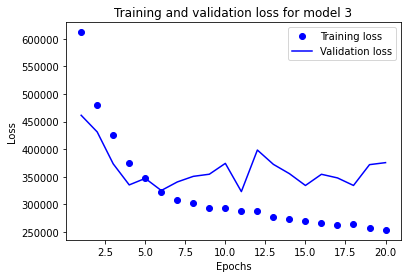

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for model 3')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('images/model3.png', dpi=1200, bbox_inches="tight")

plt.show()

## Model 4

In [16]:
model = models.Sequential()
model.add(layers.Dense(8, input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 8)                 288       
                                                                 
 dropout_6 (Dropout)         (None, 8)                 0         
                                                                 
 dense_10 (Dense)            (None, 8)                 72        
                                                                 
 dropout_7 (Dropout)         (None, 8)                 0         
                                                                 
 dense_11 (Dense)            (None, 8)                 72        
                                                                 
 dropout_8 (Dropout)         (None, 8)                 0         
                                                                 
 dense_12 (Dense)            (None, 1)                

In [17]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(
    X_test, y_test), batch_size=20, verbose=True, callbacks=[tensorboard_callback])
model.evaluate(X_test, y_test)

Epoch 1/20
297/297 [==============================] - 3s 7ms/step - loss: 963694.6875 - mae: 747.2003 - val_loss: 677811.8125 - val_mae: 568.4770
Epoch 2/20
297/297 [==============================] - 2s 5ms/step - loss: 555406.0000 - mae: 553.4389 - val_loss: 493343.6875 - val_mae: 496.4435
Epoch 3/20
297/297 [==============================] - 2s 6ms/step - loss: 474406.3750 - mae: 511.1359 - val_loss: 472256.6562 - val_mae: 480.8338
Epoch 4/20
297/297 [==============================] - 2s 6ms/step - loss: 430254.7188 - mae: 488.4185 - val_loss: 451005.2812 - val_mae: 458.8430
Epoch 5/20
297/297 [==============================] - 2s 5ms/step - loss: 383900.9688 - mae: 465.0777 - val_loss: 405204.0938 - val_mae: 434.4317
Epoch 6/20
297/297 [==============================] - 2s 5ms/step - loss: 355813.1250 - mae: 442.6372 - val_loss: 423312.2188 - val_mae: 441.3762
Epoch 7/20
297/297 [==============================] - 2s 6ms/step - loss: 347553.0000 - mae: 435.0848 - val_loss: 430575.312

[442405.25, 452.6525573730469]

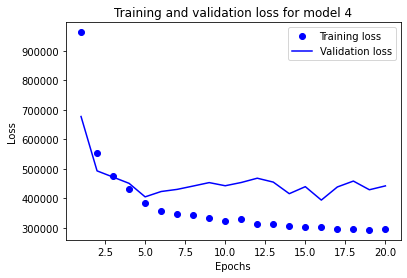

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for model 4')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('images/model4.png', dpi=1200, bbox_inches="tight")

plt.show()

## Model 5

In [19]:
model = models.Sequential()
model.add(layers.Dense(16, input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 16)                576       
                                                                 
 dropout_9 (Dropout)         (None, 16)                0         
                                                                 
 dense_14 (Dense)            (None, 16)                272       
                                                                 
 dropout_10 (Dropout)        (None, 16)                0         
                                                                 
 dense_15 (Dense)            (None, 16)                272       
                                                                 
 dropout_11 (Dropout)        (None, 16)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                

In [20]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(
    X_test, y_test), batch_size=20, verbose=True, callbacks=[tensorboard_callback])
model.evaluate(X_test, y_test)

Epoch 1/20
297/297 [==============================] - 2s 6ms/step - loss: 547081.6875 - mae: 552.9449 - val_loss: 492922.4688 - val_mae: 498.3645
Epoch 2/20
297/297 [==============================] - 2s 6ms/step - loss: 436948.5625 - mae: 501.1518 - val_loss: 492445.8750 - val_mae: 489.9519
Epoch 3/20
297/297 [==============================] - 2s 6ms/step - loss: 395793.3750 - mae: 480.0492 - val_loss: 524443.7500 - val_mae: 494.6806
Epoch 4/20
297/297 [==============================] - 2s 6ms/step - loss: 372614.9688 - mae: 464.6467 - val_loss: 455931.7812 - val_mae: 459.2624
Epoch 5/20
297/297 [==============================] - 2s 5ms/step - loss: 345824.5625 - mae: 444.8741 - val_loss: 460296.3750 - val_mae: 459.6931
Epoch 6/20
297/297 [==============================] - 2s 6ms/step - loss: 326687.7500 - mae: 425.0076 - val_loss: 440215.6250 - val_mae: 450.5923
Epoch 7/20
297/297 [==============================] - 2s 6ms/step - loss: 309563.0938 - mae: 411.6165 - val_loss: 407878.875

[419373.5625, 438.8931579589844]

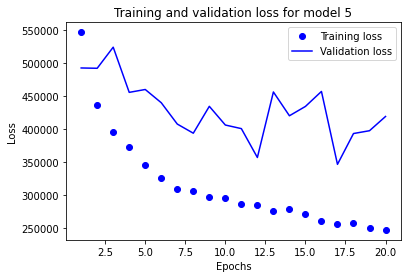

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for model 5')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('images/model5.png', dpi=1200, bbox_inches="tight")

plt.show()

## Model 6

In [22]:
model = models.Sequential()
model.add(layers.Dense(64, input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 64)                2304      
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 16)                1040      
                                                                 
 dropout_13 (Dropout)        (None, 16)                0         
                                                                 
 dense_19 (Dense)            (None, 16)                272       
                                                                 
 dropout_14 (Dropout)        (None, 16)                0         
                                                                 
 dense_20 (Dense)            (None, 1)                

In [23]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(
    X_test, y_test), batch_size=20, verbose=True, callbacks=[tensorboard_callback])
model.evaluate(X_test, y_test)

Epoch 1/20
297/297 [==============================] - 3s 7ms/step - loss: 517974.6875 - mae: 536.1050 - val_loss: 448607.2500 - val_mae: 486.7489
Epoch 2/20
297/297 [==============================] - 2s 6ms/step - loss: 421725.1562 - mae: 492.6451 - val_loss: 398782.1875 - val_mae: 457.7333
Epoch 3/20
297/297 [==============================] - 2s 5ms/step - loss: 363236.4688 - mae: 457.9366 - val_loss: 350597.7812 - val_mae: 416.8504
Epoch 4/20
297/297 [==============================] - 2s 8ms/step - loss: 330384.0625 - mae: 428.4453 - val_loss: 370881.2500 - val_mae: 417.8765
Epoch 5/20
297/297 [==============================] - 2s 6ms/step - loss: 310358.3125 - mae: 410.5732 - val_loss: 318434.1562 - val_mae: 392.2672
Epoch 6/20
297/297 [==============================] - 2s 6ms/step - loss: 297590.3125 - mae: 398.0446 - val_loss: 355268.5625 - val_mae: 411.7285
Epoch 7/20
297/297 [==============================] - 2s 6ms/step - loss: 295134.8750 - mae: 393.4627 - val_loss: 355166.375

[278107.25, 347.5434875488281]

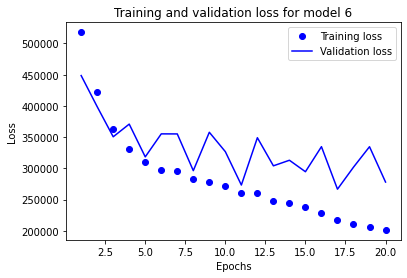

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for model 6')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('images/model6.png', dpi=1200, bbox_inches="tight")

plt.show()

## Model 7

In [25]:
model = models.Sequential()
model.add(layers.Dense(64, input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 64)                2304      
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_22 (Dense)            (None, 16)                1040      
                                                                 
 dropout_16 (Dropout)        (None, 16)                0         
                                                                 
 dense_23 (Dense)            (None, 8)                 136       
                                                                 
 dropout_17 (Dropout)        (None, 8)                 0         
                                                                 
 dense_24 (Dense)            (None, 1)                

In [26]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(
    X_test, y_test), batch_size=20, verbose=True, callbacks=[tensorboard_callback])
model.evaluate(X_test, y_test)

Epoch 1/20
297/297 [==============================] - 2s 6ms/step - loss: 586330.6250 - mae: 570.2094 - val_loss: 465070.0000 - val_mae: 489.8799
Epoch 2/20
297/297 [==============================] - 1s 5ms/step - loss: 520095.3438 - mae: 537.1004 - val_loss: 446456.6875 - val_mae: 469.4601
Epoch 3/20
297/297 [==============================] - 1s 5ms/step - loss: 470757.3125 - mae: 509.3659 - val_loss: 354310.5625 - val_mae: 433.3097
Epoch 4/20
297/297 [==============================] - 1s 4ms/step - loss: 445546.4062 - mae: 490.3186 - val_loss: 331325.1875 - val_mae: 409.2728
Epoch 5/20
297/297 [==============================] - 2s 5ms/step - loss: 453086.7188 - mae: 481.3448 - val_loss: 327647.3438 - val_mae: 403.9787
Epoch 6/20
297/297 [==============================] - 1s 4ms/step - loss: 434713.2188 - mae: 469.3151 - val_loss: 320002.7812 - val_mae: 396.0720
Epoch 7/20
297/297 [==============================] - 1s 5ms/step - loss: 422380.4375 - mae: 463.4904 - val_loss: 319798.875

[243106.171875, 325.8728332519531]

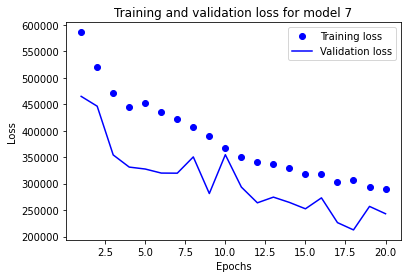

In [27]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for model 7')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('images/model7.png', dpi=1200, bbox_inches="tight")

plt.show()

## Model 8

In [28]:
model = models.Sequential()
model.add(layers.Dense(64, input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 64)                2304      
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 32)                2080      
                                                                 
 dropout_19 (Dropout)        (None, 32)                0         
                                                                 
 dense_27 (Dense)            (None, 16)                528       
                                                                 
 dropout_20 (Dropout)        (None, 16)                0         
                                                                 
 dense_28 (Dense)            (None, 8)                

In [29]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(
    X_test, y_test), batch_size=20, verbose=True, callbacks=[tensorboard_callback])
model.evaluate(X_test, y_test)

Epoch 1/20
297/297 [==============================] - 3s 6ms/step - loss: 501261.9688 - mae: 527.7084 - val_loss: 446552.3750 - val_mae: 488.0020
Epoch 2/20
297/297 [==============================] - 2s 5ms/step - loss: 449205.2188 - mae: 505.4849 - val_loss: 387052.2500 - val_mae: 455.1339
Epoch 3/20
297/297 [==============================] - 1s 5ms/step - loss: 391333.5625 - mae: 467.0110 - val_loss: 332041.4375 - val_mae: 414.5476
Epoch 4/20
297/297 [==============================] - 1s 5ms/step - loss: 352069.7500 - mae: 435.0929 - val_loss: 341130.0938 - val_mae: 403.7081
Epoch 5/20
297/297 [==============================] - 1s 5ms/step - loss: 349093.0000 - mae: 428.8713 - val_loss: 321257.8750 - val_mae: 393.4681
Epoch 6/20
297/297 [==============================] - 2s 6ms/step - loss: 340158.5938 - mae: 419.9535 - val_loss: 322413.6562 - val_mae: 392.1936
Epoch 7/20
297/297 [==============================] - 2s 5ms/step - loss: 338471.5000 - mae: 415.6695 - val_loss: 352700.375

[268319.78125, 344.271484375]

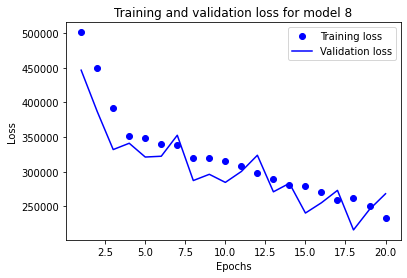

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for model 8')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('images/model8.png', dpi=1200, bbox_inches="tight")

plt.show()

## Model 9

In [31]:
model = models.Sequential()
model.add(layers.Dense(128, input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(64, input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 128)               4608      
                                                                 
 dropout_22 (Dropout)        (None, 128)               0         
                                                                 
 dense_31 (Dense)            (None, 64)                8256      
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                                 
 dense_32 (Dense)            (None, 32)                2080      
                                                                 
 dropout_24 (Dropout)        (None, 32)                0         
                                                                 
 dense_33 (Dense)            (None, 16)               

In [32]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(
    X_test, y_test), batch_size=20, verbose=True, callbacks=[tensorboard_callback])
model.evaluate(X_test, y_test)

Epoch 1/20
297/297 [==============================] - 3s 7ms/step - loss: 590961.5625 - mae: 568.0699 - val_loss: 480064.3438 - val_mae: 490.3950
Epoch 2/20
297/297 [==============================] - 2s 6ms/step - loss: 506168.4375 - mae: 525.7046 - val_loss: 363255.1562 - val_mae: 434.9696
Epoch 3/20
297/297 [==============================] - 2s 6ms/step - loss: 441984.5000 - mae: 482.5344 - val_loss: 371483.0938 - val_mae: 417.2408
Epoch 4/20
297/297 [==============================] - 2s 6ms/step - loss: 436624.1875 - mae: 472.3549 - val_loss: 382274.2188 - val_mae: 419.4944
Epoch 5/20
297/297 [==============================] - 2s 6ms/step - loss: 422819.4375 - mae: 463.4154 - val_loss: 404792.7812 - val_mae: 430.4387
Epoch 6/20
297/297 [==============================] - 2s 6ms/step - loss: 416622.7812 - mae: 456.9377 - val_loss: 352955.7812 - val_mae: 402.4734
Epoch 7/20
297/297 [==============================] - 2s 6ms/step - loss: 413139.0312 - mae: 451.4151 - val_loss: 492354.718

[441330.75, 453.5530090332031]

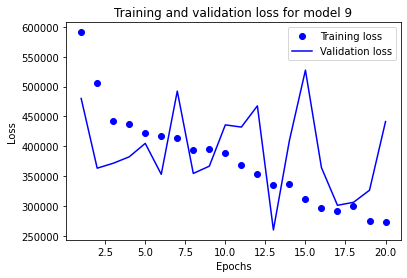

In [33]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for model 9')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('images/model9.png', dpi=1200, bbox_inches="tight")

plt.show()

## Model 10

In [34]:
model = models.Sequential()
model.add(layers.Dense(128, input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(64, input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 128)               4608      
                                                                 
 dropout_28 (Dropout)        (None, 128)               0         
                                                                 
 dense_38 (Dense)            (None, 64)                8256      
                                                                 
 dropout_29 (Dropout)        (None, 64)                0         
                                                                 
 dense_39 (Dense)            (None, 32)                2080      
                                                                 
 dropout_30 (Dropout)        (None, 32)                0         
                                                                 
 dense_40 (Dense)            (None, 16)               

In [35]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(
    X_test, y_test), batch_size=30, verbose=True, callbacks=[tensorboard_callback])
model.evaluate(X_test, y_test)

Epoch 1/20
198/198 [==============================] - 3s 7ms/step - loss: 599287.3750 - mae: 575.3149 - val_loss: 446525.1875 - val_mae: 489.8577
Epoch 2/20
198/198 [==============================] - 1s 6ms/step - loss: 531800.3750 - mae: 538.9100 - val_loss: 455436.5000 - val_mae: 467.6689
Epoch 3/20
198/198 [==============================] - 1s 6ms/step - loss: 466199.7188 - mae: 495.3411 - val_loss: 468949.2812 - val_mae: 462.6670
Epoch 4/20
198/198 [==============================] - 1s 7ms/step - loss: 447553.4062 - mae: 477.3280 - val_loss: 338216.4062 - val_mae: 409.0327
Epoch 5/20
198/198 [==============================] - 1s 6ms/step - loss: 446647.2812 - mae: 477.2352 - val_loss: 365953.2812 - val_mae: 411.7568
Epoch 6/20
198/198 [==============================] - 1s 6ms/step - loss: 422492.1562 - mae: 459.7388 - val_loss: 378878.8750 - val_mae: 415.9293
Epoch 7/20
198/198 [==============================] - 1s 6ms/step - loss: 418623.5938 - mae: 452.6543 - val_loss: 363266.781

[310275.5, 370.4684143066406]

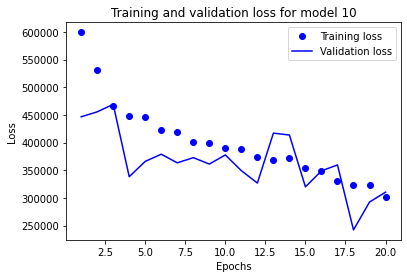

In [36]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for model 10')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('images/model10.png', dpi=1200, bbox_inches="tight")

plt.show()

## Model 11 (Resetting to Model 8)

In [37]:
num_epochs = 100

In [38]:
model = models.Sequential()
model.add(layers.Dense(64, input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 64)                2304      
                                                                 
 dropout_34 (Dropout)        (None, 64)                0         
                                                                 
 dense_45 (Dense)            (None, 32)                2080      
                                                                 
 dropout_35 (Dropout)        (None, 32)                0         
                                                                 
 dense_46 (Dense)            (None, 16)                528       
                                                                 
 dropout_36 (Dropout)        (None, 16)                0         
                                                                 
 dense_47 (Dense)            (None, 8)               

In [39]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(
    X_test, y_test), batch_size=20, verbose=True, callbacks=[tensorboard_callback])
model.evaluate(X_test, y_test)

Epoch 1/100
297/297 [==============================] - 3s 5ms/step - loss: 515536.3125 - mae: 534.1248 - val_loss: 454244.7500 - val_mae: 488.8588
Epoch 2/100
297/297 [==============================] - 1s 5ms/step - loss: 456974.9375 - mae: 508.0603 - val_loss: 405099.1250 - val_mae: 454.6916
Epoch 3/100
297/297 [==============================] - 2s 5ms/step - loss: 413494.8438 - mae: 475.7277 - val_loss: 328250.3438 - val_mae: 410.4998
Epoch 4/100
297/297 [==============================] - 2s 6ms/step - loss: 385558.7812 - mae: 450.6953 - val_loss: 328672.7500 - val_mae: 401.0699
Epoch 5/100
297/297 [==============================] - 1s 5ms/step - loss: 372335.2188 - mae: 439.3372 - val_loss: 341113.4688 - val_mae: 402.4224
Epoch 6/100
297/297 [==============================] - 2s 6ms/step - loss: 377173.7500 - mae: 437.8037 - val_loss: 339852.2812 - val_mae: 400.1456
Epoch 7/100
297/297 [==============================] - 1s 5ms/step - loss: 355541.4062 - mae: 426.0055 - val_loss: 302

297/297 [==============================] - 2s 5ms/step - loss: 178907.5938 - mae: 286.1475 - val_loss: 145388.0781 - val_mae: 258.0132
Epoch 57/100
297/297 [==============================] - 2s 5ms/step - loss: 177494.0000 - mae: 286.9570 - val_loss: 165644.5469 - val_mae: 279.6107
Epoch 58/100
297/297 [==============================] - 2s 5ms/step - loss: 177360.6562 - mae: 285.5518 - val_loss: 116901.0547 - val_mae: 232.5373
Epoch 59/100
297/297 [==============================] - 2s 5ms/step - loss: 183571.2344 - mae: 289.0988 - val_loss: 105298.9453 - val_mae: 215.7416
Epoch 60/100
297/297 [==============================] - 1s 5ms/step - loss: 179310.9375 - mae: 284.1868 - val_loss: 117113.2969 - val_mae: 232.5363
Epoch 61/100
297/297 [==============================] - 2s 6ms/step - loss: 165671.2188 - mae: 275.1157 - val_loss: 168307.4531 - val_mae: 306.7491
Epoch 62/100
297/297 [==============================] - 2s 5ms/step - loss: 186948.7188 - mae: 288.7765 - val_loss: 117414.25

[95658.0625, 209.69851684570312]

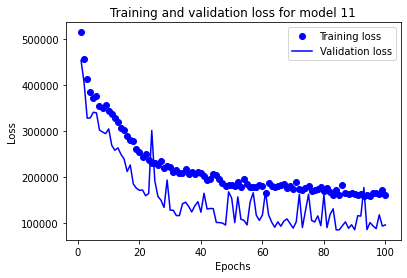

In [40]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for model 11')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('images/model11.png', dpi=1200, bbox_inches="tight")

plt.show()

## Model 12

In [41]:
model = models.Sequential()
model.add(layers.Dense(64, input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_49 (Dense)            (None, 64)                2304      
                                                                 
 dropout_38 (Dropout)        (None, 64)                0         
                                                                 
 dense_50 (Dense)            (None, 32)                2080      
                                                                 
 dropout_39 (Dropout)        (None, 32)                0         
                                                                 
 dense_51 (Dense)            (None, 16)                528       
                                                                 
 dropout_40 (Dropout)        (None, 16)                0         
                                                                 
 dense_52 (Dense)            (None, 8)               

In [42]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(
    X_test, y_test), batch_size=30, verbose=True, callbacks=[tensorboard_callback])
model.evaluate(X_test, y_test)

Epoch 1/100
198/198 [==============================] - 2s 7ms/step - loss: 615177.8750 - mae: 577.4196 - val_loss: 489701.1875 - val_mae: 500.3895
Epoch 2/100
198/198 [==============================] - 1s 5ms/step - loss: 509067.5000 - mae: 531.6438 - val_loss: 479671.5938 - val_mae: 489.8226
Epoch 3/100
198/198 [==============================] - 1s 6ms/step - loss: 471652.5312 - mae: 513.5572 - val_loss: 390808.7812 - val_mae: 447.9368
Epoch 4/100
198/198 [==============================] - 1s 5ms/step - loss: 432383.4688 - mae: 483.9099 - val_loss: 373213.4062 - val_mae: 423.5190
Epoch 5/100
198/198 [==============================] - 1s 5ms/step - loss: 414781.2188 - mae: 465.1122 - val_loss: 357744.1250 - val_mae: 411.2179
Epoch 6/100
198/198 [==============================] - 1s 5ms/step - loss: 392721.4062 - mae: 452.8787 - val_loss: 353143.9375 - val_mae: 408.3472
Epoch 7/100
198/198 [==============================] - 1s 5ms/step - loss: 385293.6562 - mae: 443.1254 - val_loss: 306

198/198 [==============================] - 1s 6ms/step - loss: 225627.0156 - mae: 318.5970 - val_loss: 105371.9297 - val_mae: 214.4979
Epoch 57/100
198/198 [==============================] - 1s 6ms/step - loss: 222472.8281 - mae: 309.9420 - val_loss: 103958.1953 - val_mae: 210.5344
Epoch 58/100
198/198 [==============================] - 1s 6ms/step - loss: 233583.7812 - mae: 321.2366 - val_loss: 105376.9297 - val_mae: 214.4255
Epoch 59/100
198/198 [==============================] - 1s 5ms/step - loss: 209902.9688 - mae: 309.2236 - val_loss: 126645.5938 - val_mae: 234.8258
Epoch 60/100
198/198 [==============================] - 1s 5ms/step - loss: 218413.7812 - mae: 310.2849 - val_loss: 146350.6562 - val_mae: 256.5218
Epoch 61/100
198/198 [==============================] - 1s 5ms/step - loss: 211895.7344 - mae: 303.6903 - val_loss: 100076.4766 - val_mae: 207.6293
Epoch 62/100
198/198 [==============================] - 1s 6ms/step - loss: 230332.5156 - mae: 322.2671 - val_loss: 97911.125

[89366.5546875, 202.63851928710938]

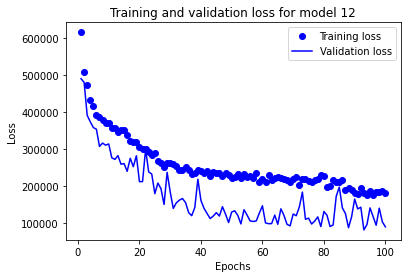

In [43]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for model 12')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('images/model12.png', dpi=1200, bbox_inches="tight")

plt.show()

## Model 13

In [44]:
model = models.Sequential()
model.add(layers.Dense(64, input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 64)                2304      
                                                                 
 dropout_42 (Dropout)        (None, 64)                0         
                                                                 
 dense_55 (Dense)            (None, 32)                2080      
                                                                 
 dropout_43 (Dropout)        (None, 32)                0         
                                                                 
 dense_56 (Dense)            (None, 16)                528       
                                                                 
 dropout_44 (Dropout)        (None, 16)                0         
                                                                 
 dense_57 (Dense)            (None, 8)               

In [45]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(
    X_test, y_test), batch_size=100, verbose=True, callbacks=[tensorboard_callback])
model.evaluate(X_test, y_test)

Epoch 1/100
60/60 [==============================] - 2s 10ms/step - loss: 569521.6875 - mae: 557.0575 - val_loss: 490831.9688 - val_mae: 502.7907
Epoch 2/100
60/60 [==============================] - 0s 7ms/step - loss: 518975.5000 - mae: 540.4214 - val_loss: 488857.0312 - val_mae: 499.5963
Epoch 3/100
60/60 [==============================] - 0s 6ms/step - loss: 497640.9375 - mae: 527.2963 - val_loss: 440548.8438 - val_mae: 489.6681
Epoch 4/100
60/60 [==============================] - 0s 5ms/step - loss: 463302.3125 - mae: 511.0401 - val_loss: 456515.2812 - val_mae: 483.4012
Epoch 5/100
60/60 [==============================] - 0s 5ms/step - loss: 460869.2188 - mae: 507.9683 - val_loss: 444673.3750 - val_mae: 471.7825
Epoch 6/100
60/60 [==============================] - 0s 5ms/step - loss: 425439.1250 - mae: 487.5388 - val_loss: 386675.9688 - val_mae: 455.0298
Epoch 7/100
60/60 [==============================] - 0s 6ms/step - loss: 417132.8750 - mae: 485.8939 - val_loss: 374587.3125 - va

60/60 [==============================] - 0s 5ms/step - loss: 188135.5469 - mae: 295.8886 - val_loss: 114555.2891 - val_mae: 230.1632
Epoch 58/100
60/60 [==============================] - 0s 5ms/step - loss: 187913.6719 - mae: 296.8964 - val_loss: 114009.8750 - val_mae: 238.1526
Epoch 59/100
60/60 [==============================] - 0s 6ms/step - loss: 177560.7188 - mae: 287.9519 - val_loss: 113866.7969 - val_mae: 228.7383
Epoch 60/100
60/60 [==============================] - 0s 7ms/step - loss: 187628.9219 - mae: 294.3420 - val_loss: 108140.3203 - val_mae: 227.8087
Epoch 61/100
60/60 [==============================] - 0s 5ms/step - loss: 188657.7188 - mae: 297.8353 - val_loss: 138861.1719 - val_mae: 248.5047
Epoch 62/100
60/60 [==============================] - 0s 5ms/step - loss: 189650.8281 - mae: 298.2858 - val_loss: 110881.4219 - val_mae: 232.7577
Epoch 63/100
60/60 [==============================] - 0s 5ms/step - loss: 178188.4531 - mae: 292.4773 - val_loss: 133821.0938 - val_mae: 

[128911.2578125, 244.74220275878906]

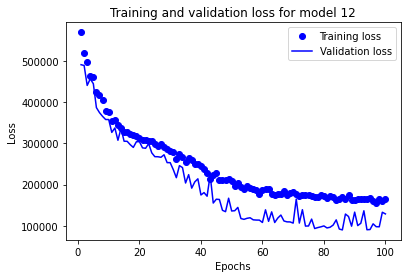

In [46]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for model 12')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('images/model13.png', dpi=1200, bbox_inches="tight")

plt.show()

## Model 14 (Back to Model 12)

In [47]:
model = models.Sequential()
model.add(layers.Dense(64, input_shape=(X_train.shape[1],), kernel_regularizer='l1_l2'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(32, activation='relu', kernel_regularizer='l1_l2'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(16, activation='relu', kernel_regularizer='l1_l2'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(8, activation='relu', kernel_regularizer='l1_l2'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_59 (Dense)            (None, 64)                2304      
                                                                 
 dropout_46 (Dropout)        (None, 64)                0         
                                                                 
 dense_60 (Dense)            (None, 32)                2080      
                                                                 
 dropout_47 (Dropout)        (None, 32)                0         
                                                                 
 dense_61 (Dense)            (None, 16)                528       
                                                                 
 dropout_48 (Dropout)        (None, 16)                0         
                                                                 
 dense_62 (Dense)            (None, 8)               

In [48]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(
    X_test, y_test), batch_size=30, verbose=True, callbacks=[tensorboard_callback])
model.evaluate(X_test, y_test)

Epoch 1/100
198/198 [==============================] - 2s 8ms/step - loss: 606185.2500 - mae: 578.3929 - val_loss: 462978.4688 - val_mae: 492.7571
Epoch 2/100
198/198 [==============================] - 1s 6ms/step - loss: 474589.0312 - mae: 509.6453 - val_loss: 411221.2812 - val_mae: 465.8006
Epoch 3/100
198/198 [==============================] - 1s 7ms/step - loss: 428724.5938 - mae: 485.6826 - val_loss: 352558.3438 - val_mae: 422.9554
Epoch 4/100
198/198 [==============================] - 1s 7ms/step - loss: 399547.4688 - mae: 464.9831 - val_loss: 310618.7188 - val_mae: 404.6029
Epoch 5/100
198/198 [==============================] - 1s 7ms/step - loss: 372022.7500 - mae: 441.9196 - val_loss: 301471.6562 - val_mae: 388.5638
Epoch 6/100
198/198 [==============================] - 1s 6ms/step - loss: 361594.5625 - mae: 428.9716 - val_loss: 315581.8438 - val_mae: 389.7782
Epoch 7/100
198/198 [==============================] - 1s 7ms/step - loss: 361172.2500 - mae: 430.7903 - val_loss: 307

198/198 [==============================] - 1s 7ms/step - loss: 198409.7656 - mae: 295.0941 - val_loss: 98879.4766 - val_mae: 207.4694
Epoch 57/100
198/198 [==============================] - 1s 7ms/step - loss: 190789.4531 - mae: 291.7395 - val_loss: 107862.4375 - val_mae: 218.2866
Epoch 58/100
198/198 [==============================] - 1s 6ms/step - loss: 189825.7969 - mae: 292.5332 - val_loss: 94413.6094 - val_mae: 214.1235
Epoch 59/100
198/198 [==============================] - 1s 7ms/step - loss: 204602.5312 - mae: 300.6315 - val_loss: 119499.7812 - val_mae: 228.8236
Epoch 60/100
198/198 [==============================] - 1s 6ms/step - loss: 190653.1562 - mae: 293.1837 - val_loss: 102858.2266 - val_mae: 212.0028
Epoch 61/100
198/198 [==============================] - 2s 9ms/step - loss: 192179.1719 - mae: 294.4177 - val_loss: 112920.3281 - val_mae: 222.1171
Epoch 62/100
198/198 [==============================] - 1s 7ms/step - loss: 186689.3281 - mae: 288.9983 - val_loss: 105630.5469

[81229.84375, 188.3810272216797]

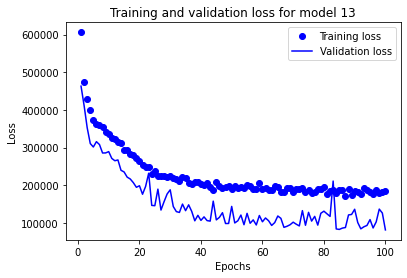

In [49]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for model 13')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('images/model14.png', dpi=1200, bbox_inches="tight")

plt.show()

## Model 15 (Reset to Model 12)

In [50]:
model = models.Sequential()
model.add(layers.Dense(64, input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)            (None, 64)                2304      
                                                                 
 dropout_50 (Dropout)        (None, 64)                0         
                                                                 
 dense_65 (Dense)            (None, 32)                2080      
                                                                 
 dropout_51 (Dropout)        (None, 32)                0         
                                                                 
 dense_66 (Dense)            (None, 16)                528       
                                                                 
 dropout_52 (Dropout)        (None, 16)                0         
                                                                 
 dense_67 (Dense)            (None, 8)               

In [51]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(
    X_test, y_test), batch_size=40, verbose=True, callbacks=[tensorboard_callback])
model.evaluate(X_test, y_test)

Epoch 1/100
149/149 [==============================] - 2s 7ms/step - loss: 527465.6875 - mae: 540.6633 - val_loss: 459236.6250 - val_mae: 492.7249
Epoch 2/100
149/149 [==============================] - 1s 9ms/step - loss: 472589.0938 - mae: 515.5250 - val_loss: 428354.9688 - val_mae: 476.1784
Epoch 3/100
149/149 [==============================] - 1s 6ms/step - loss: 437609.0312 - mae: 498.0625 - val_loss: 383228.4062 - val_mae: 443.7376
Epoch 4/100
149/149 [==============================] - 1s 6ms/step - loss: 391227.3125 - mae: 466.8452 - val_loss: 379566.8438 - val_mae: 427.5253
Epoch 5/100
149/149 [==============================] - 1s 5ms/step - loss: 368600.5000 - mae: 447.7231 - val_loss: 320202.5625 - val_mae: 399.5886
Epoch 6/100
149/149 [==============================] - 1s 5ms/step - loss: 353797.4688 - mae: 435.7429 - val_loss: 297158.2188 - val_mae: 394.2704
Epoch 7/100
149/149 [==============================] - 1s 5ms/step - loss: 349115.0938 - mae: 428.3988 - val_loss: 297

149/149 [==============================] - 1s 5ms/step - loss: 166764.8906 - mae: 276.8660 - val_loss: 101637.9062 - val_mae: 215.1109
Epoch 57/100
149/149 [==============================] - 1s 5ms/step - loss: 161562.0312 - mae: 272.0520 - val_loss: 150931.3125 - val_mae: 266.9099
Epoch 58/100
149/149 [==============================] - 1s 6ms/step - loss: 169063.1094 - mae: 279.4445 - val_loss: 119928.7188 - val_mae: 238.4877
Epoch 59/100
149/149 [==============================] - 1s 5ms/step - loss: 162524.7812 - mae: 273.8185 - val_loss: 121531.7422 - val_mae: 236.6584
Epoch 60/100
149/149 [==============================] - 1s 5ms/step - loss: 166685.9688 - mae: 276.9201 - val_loss: 142707.8906 - val_mae: 255.1094
Epoch 61/100
149/149 [==============================] - 1s 6ms/step - loss: 158181.7188 - mae: 273.3431 - val_loss: 159056.7031 - val_mae: 275.5990
Epoch 62/100
149/149 [==============================] - 1s 6ms/step - loss: 169124.3750 - mae: 280.7159 - val_loss: 127239.23

[144304.984375, 254.89633178710938]

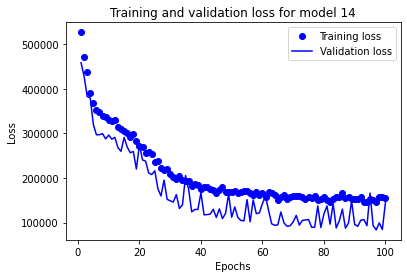

In [52]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for model 14')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('images/model15.png', dpi=1200, bbox_inches="tight")

plt.show()

## Model 16 (Reset to Model 12)

In [53]:
model = models.Sequential()
model.add(layers.Dense(64, input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_69 (Dense)            (None, 64)                2304      
                                                                 
 dropout_54 (Dropout)        (None, 64)                0         
                                                                 
 dense_70 (Dense)            (None, 32)                2080      
                                                                 
 dropout_55 (Dropout)        (None, 32)                0         
                                                                 
 dense_71 (Dense)            (None, 16)                528       
                                                                 
 dropout_56 (Dropout)        (None, 16)                0         
                                                                 
 dense_72 (Dense)            (None, 8)               

In [54]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(
    X_test, y_test), batch_size=30, verbose=True, callbacks=[tensorboard_callback])
model.evaluate(X_test, y_test)

Epoch 1/100
198/198 [==============================] - 2s 6ms/step - loss: 557469.0000 - mae: 552.1284 - val_loss: 506234.7188 - val_mae: 503.1486
Epoch 2/100
198/198 [==============================] - 1s 5ms/step - loss: 511233.0000 - mae: 533.9349 - val_loss: 506616.8438 - val_mae: 495.1884
Epoch 3/100
198/198 [==============================] - 1s 5ms/step - loss: 493142.4688 - mae: 519.0392 - val_loss: 440163.3750 - val_mae: 461.7601
Epoch 4/100
198/198 [==============================] - 1s 5ms/step - loss: 448387.5312 - mae: 493.2529 - val_loss: 454363.1562 - val_mae: 454.1580
Epoch 5/100
198/198 [==============================] - 1s 6ms/step - loss: 431227.0625 - mae: 474.0203 - val_loss: 427885.5000 - val_mae: 440.7765
Epoch 6/100
198/198 [==============================] - 1s 7ms/step - loss: 402064.7500 - mae: 461.1763 - val_loss: 419796.6250 - val_mae: 436.8420
Epoch 7/100
198/198 [==============================] - 1s 6ms/step - loss: 420279.5938 - mae: 460.0583 - val_loss: 361

198/198 [==============================] - 1s 6ms/step - loss: 211723.8750 - mae: 307.9970 - val_loss: 178809.3906 - val_mae: 275.7336
Epoch 57/100
198/198 [==============================] - 1s 6ms/step - loss: 201553.7969 - mae: 303.0413 - val_loss: 232007.9375 - val_mae: 319.4989
Epoch 58/100
198/198 [==============================] - 1s 5ms/step - loss: 196084.8906 - mae: 296.5653 - val_loss: 172173.3750 - val_mae: 269.9886
Epoch 59/100
198/198 [==============================] - 1s 6ms/step - loss: 208804.6406 - mae: 304.6622 - val_loss: 262851.5938 - val_mae: 349.8362
Epoch 60/100
198/198 [==============================] - 1s 5ms/step - loss: 196408.5625 - mae: 295.8817 - val_loss: 248242.3906 - val_mae: 332.4643
Epoch 61/100
198/198 [==============================] - 1s 6ms/step - loss: 194006.7969 - mae: 292.0724 - val_loss: 157525.4688 - val_mae: 258.1308
Epoch 62/100
198/198 [==============================] - 1s 5ms/step - loss: 196566.5156 - mae: 295.4657 - val_loss: 288216.90

[218261.234375, 311.99359130859375]

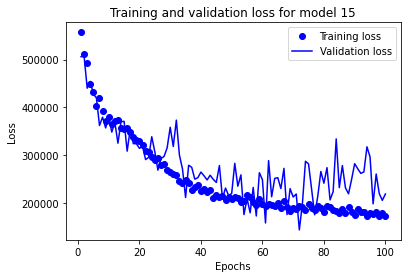

In [55]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for model 15')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('images/model16.png', dpi=1200, bbox_inches="tight")

plt.show()

## Plotting Predicted vs Actual values using Model 12

In [56]:
# recreate model 12
model = models.Sequential()
model.add(layers.Dense(64, input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_75 (Dense)            (None, 64)                2304      
                                                                 
 dropout_59 (Dropout)        (None, 64)                0         
                                                                 
 dense_76 (Dense)            (None, 32)                2080      
                                                                 
 dropout_60 (Dropout)        (None, 32)                0         
                                                                 
 dense_77 (Dense)            (None, 16)                528       
                                                                 
 dropout_61 (Dropout)        (None, 16)                0         
                                                                 
 dense_78 (Dense)            (None, 8)               

In [57]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(
    X_test, y_test), batch_size=30, verbose=True, callbacks=[tensorboard_callback])

Epoch 1/100
198/198 [==============================] - 3s 7ms/step - loss: 558258.5000 - mae: 552.2510 - val_loss: 451702.0625 - val_mae: 487.8148
Epoch 2/100
198/198 [==============================] - 1s 5ms/step - loss: 470013.1875 - mae: 512.9542 - val_loss: 431003.1250 - val_mae: 462.7656
Epoch 3/100
198/198 [==============================] - 1s 5ms/step - loss: 425465.3750 - mae: 483.1052 - val_loss: 370976.7812 - val_mae: 423.2768
Epoch 4/100
198/198 [==============================] - 1s 5ms/step - loss: 396163.4375 - mae: 459.4781 - val_loss: 397611.7812 - val_mae: 431.1485
Epoch 5/100
198/198 [==============================] - 1s 5ms/step - loss: 369216.3750 - mae: 435.9872 - val_loss: 298996.1875 - val_mae: 386.1995
Epoch 6/100
198/198 [==============================] - 1s 5ms/step - loss: 358063.4688 - mae: 427.8593 - val_loss: 324420.1875 - val_mae: 396.5673
Epoch 7/100
198/198 [==============================] - 1s 5ms/step - loss: 348897.5000 - mae: 423.2594 - val_loss: 294

198/198 [==============================] - 1s 5ms/step - loss: 185386.8125 - mae: 291.9909 - val_loss: 97201.2812 - val_mae: 206.6119
Epoch 57/100
198/198 [==============================] - 1s 5ms/step - loss: 180206.9375 - mae: 285.1092 - val_loss: 89393.8047 - val_mae: 200.2267
Epoch 58/100
198/198 [==============================] - 1s 5ms/step - loss: 174951.4688 - mae: 285.2022 - val_loss: 96553.7422 - val_mae: 209.6415
Epoch 59/100
198/198 [==============================] - 1s 5ms/step - loss: 178111.2500 - mae: 283.5092 - val_loss: 98483.7266 - val_mae: 206.9753
Epoch 60/100
198/198 [==============================] - 1s 5ms/step - loss: 182805.5781 - mae: 288.2516 - val_loss: 97609.9688 - val_mae: 209.5888
Epoch 61/100
198/198 [==============================] - 1s 5ms/step - loss: 162790.3906 - mae: 274.0070 - val_loss: 126546.3906 - val_mae: 236.9939
Epoch 62/100
198/198 [==============================] - 1s 5ms/step - loss: 180147.4219 - mae: 283.5089 - val_loss: 92673.4844 - v

In [58]:
prediction = model.predict(X_test, batch_size=30, verbose=True)
model.evaluate(X_test,y_test)

80/80 [==============================] - 8s 102ms/step - loss: 97321.2656 - mae: 209.5003


[97321.265625, 209.5002899169922]

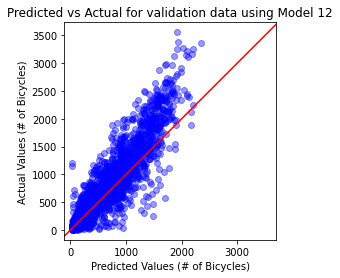

In [59]:
plt.plot(prediction, y_test, 'bo', alpha = 0.4)
plt.axline((0,0), slope=1, color='red')
plt.title('Predicted vs Actual for validation data using Model 12')
plt.xlabel('Predicted Values (# of Bicycles)')
plt.ylabel('Actual Values (# of Bicycles)')
plt.xlim(right=3700)
plt.gca().set_aspect(1.0)

plt.savefig('images/predictactual.png', dpi=1200, bbox_inches="tight")

plt.show()

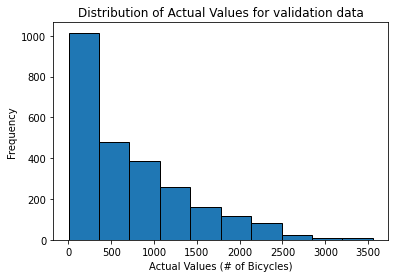

In [60]:
plt.hist(y_test, ec="black")
plt.title('Distribution of Actual Values for validation data')
plt.xlabel('Actual Values (# of Bicycles)')
plt.ylabel('Frequency')

plt.savefig('images/histo.png', dpi=1200, bbox_inches="tight")

plt.show()

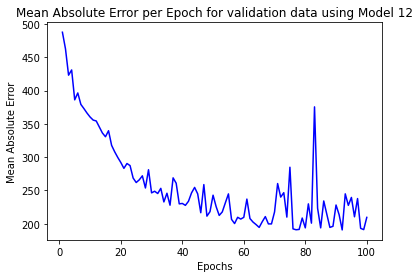

In [61]:
val_mae = history.history['val_mae']

epochs = range(1, len(val_mae) + 1)

plt.plot(epochs, val_mae, 'b')
plt.title('Mean Absolute Error per Epoch for validation data using Model 12')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')

plt.savefig('images/mae.png', dpi=1200, bbox_inches="tight")

plt.show()